In [24]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  # p<0.05, Stationary

In [26]:
ten_stocks_close = pd.read_csv('close_df.csv')

In [27]:
pool = ["600094.XSHG",    
        "600160.XSHG", 
        "600008.XSHG",
        "600903.XSHG",
        "000959.XSHE",
        "600970.XSHG",
        "002302.XSHE",
        "600823.XSHG",
        "002503.XSHE",
        "600664.XSHG"]

In [28]:
close_price = ten_stocks_close['000959.XSHE'].dropna()

## Ljung Box Test on close price

In [29]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(close_price, lags=[12], return_df=True) # The p-value closes to 0. Has dependency

,lb_stat,lb_pvalue
12,16169.34219,0.0


## Stationarity on close price first

In [30]:
test_stationarity(close_price) # p-value is larger than 0.05. Has unit root

Results of Dickey-Fuller Test:
Test Statistic                   -1.796174
p-value                           0.382363
#Lags Used                        5.000000
Number of Observations Used    1420.000000
Critical Value (1%)              -3.434963
Critical Value (5%)              -2.863578
Critical Value (10%)             -2.567855
dtype: float64


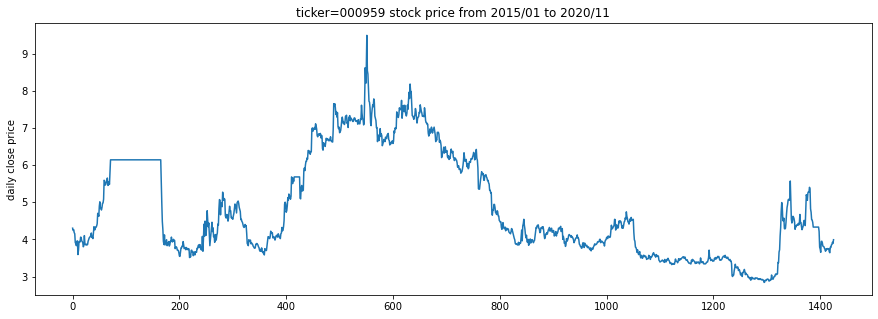

In [31]:
# visualize daily close data, lable y = column 1, ticker = 600094
close_price.plot(figsize=(15,5))
plt.ylabel('daily close price')
plt.title('ticker=000959 stock price from 2015/01 to 2020/11')
plt.show()

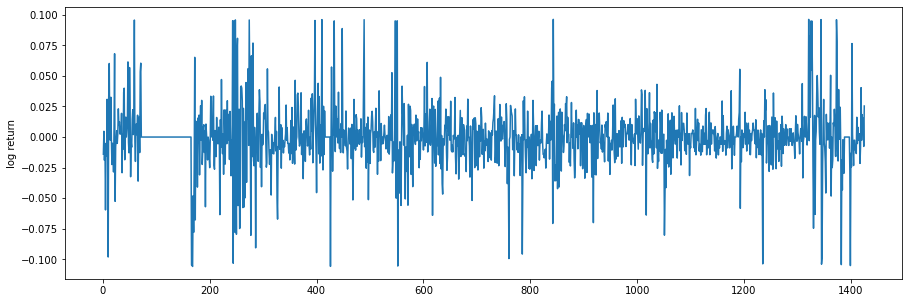

In [32]:
log_rtn = np.log(close_price).diff(1).dropna()
log_rtn.plot(figsize=(15,5))
plt.ylabel('log return')
plt.show()

## Test stationarity

In [33]:
test_stationarity(log_rtn) #p-value is small, it's stationary

Results of Dickey-Fuller Test:
Test Statistic                  -19.836142
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    1422.000000
Critical Value (1%)              -3.434957
Critical Value (5%)              -2.863575
Critical Value (10%)             -2.567853
dtype: float64


## ACF & PACF

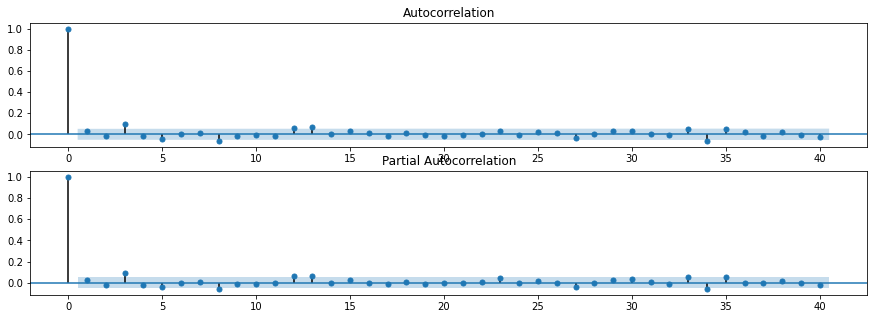

In [34]:
# acf & pacf for log return
import statsmodels.api as sm
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_rtn, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_rtn, lags=40, ax=ax2)

## Distribution of log return

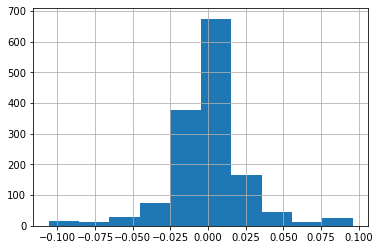

In [35]:
log_rtn.hist()
plt.show()

## Fit ARMA Model

In [36]:
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

p = range(5)
q = range(5)

combinations = list(itertools.product(p, q))
combinations = combinations[1:] # Drop (0,0)
def train_ARMA(param):
    p = param[0]
    q = param[1]
    model = ARIMA(log_rtn, order=(p,0,q))
    
    model_fit = model.fit(disp=0)
    
    ljung_p = sm.stats.acorr_ljungbox(model_fit.resid, lags=[12-p-q], return_df=True).values[0][1]
    aic = model_fit.aic
    return {'p': p, 'q': q, 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_ARMA(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

,p,q,ljung_p,aic
23,4.0,4.0,0.911675,-6461.839070
14,3.0,0.0,0.557689,-6460.674017
16,3.0,2.0,0.879175,-6460.507590
2,0.0,3.0,0.535667,-6460.492376
12,2.0,3.0,0.998756,-6459.981875
17,3.0,3.0,0.897357,-6459.441936
21,4.0,2.0,0.896701,-6459.265327
19,4.0,0.0,0.557713,-6459.176605
13,2.0,4.0,0.876770,-6459.001908
15,3.0,1.0,0.525275,-6458.942630


## GARCH

In [37]:
mean = log_rtn.mean() # The mean closes to 0

### Check if volatility time dependency

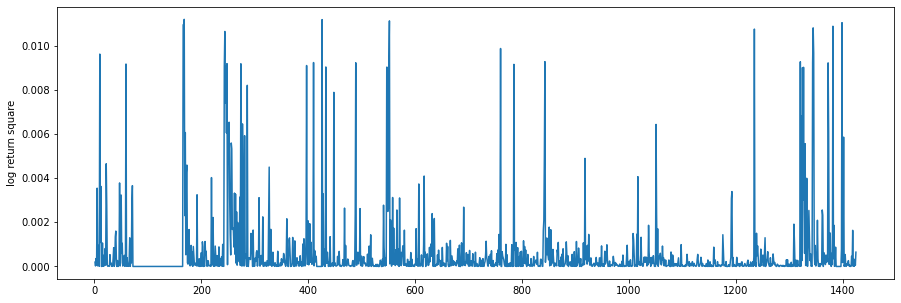

In [38]:
#log return square 
log_rtn_square = np.square(log_rtn - mean)
log_rtn_square.plot(figsize=(15,5))
plt.ylabel('log return square')
plt.show()

In [39]:
import statsmodels.api as sm

p_2 = sm.stats.acorr_ljungbox(log_rtn_square, lags=[40], return_df=True)['lb_pvalue'].values[0] # log return square is white noise if p < 0.05

print(f"P-value for squared log return: {p_2}")
if (p_2<0.05):
    print("Conclusion: Has ARCH's property in log rtn")
else:
    print("Conclusion: No ARCH's property in log rtn")

P-value for squared log return: 1.7217643521899886e-84
Conclusion: Has ARCH's property in log rtn


In [40]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_GARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, mean='constant', p=p, q=q)
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    
    return {'p':p, 'q': q, 'alpha': res.params['alpha[1]'], 'beta': res.params['beta[1]'], 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'alpha', 'beta', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_GARCH(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3383.9315027923512
            Iterations: 2
            Function evaluations: 27
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3399.7322785193114
            Iterations: 15
            Function evaluations: 119
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3402.0686682644173
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3373.926250468638
            Iterations: 18
            Function evaluations: 179
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3402.380120228369
            Iterations: 22
            Function ev

,p,q,alpha,beta,ljung_p,aic
4,2.0,2.0,0.159801,0.277133,0.641202,-6792.760240
2,1.0,3.0,0.199980,0.233310,0.750379,-6792.137337
1,1.0,2.0,0.179577,0.314260,0.714822,-6789.464557
5,2.0,3.0,0.102081,0.233169,0.635875,-6772.643140
0,1.0,1.0,0.200000,0.700000,0.759918,-6759.863006
8,3.0,3.0,0.066913,0.233272,0.533481,-6753.104629
7,3.0,2.0,0.097326,0.338513,0.647518,-6751.264037
3,2.0,1.0,0.100006,0.700001,0.658160,-6737.852501
6,3.0,1.0,0.066667,0.700000,0.608532,-6721.078579


## EGARCH

In [41]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_EGARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, vol='EGARCH', mean='constant', p=p, q=q, dist='t')
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    return {'p':p, 'q': q, 'params': res.params, 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'params', 'ljung_p', 'aic'])

for pq in combinations:
    results = results.append(train_EGARCH(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5494.719055631493
            Iterations: 4
            Function evaluations: 54
            Gradient evaluations: 4
Positive directional derivative for linesearch    (Exit mode 8)

C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,



            Current function value: 9472.00879116948
            Iterations: 59
            Function evaluations: 543
            Gradient evaluations: 55
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5745.730066246845
            Iterations: 4
            Function evaluations: 62
            Gradient evaluations: 4


C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -3721.9253472074165
            Iterations: 91
            Function evaluations: 710
            Gradient evaluations: 91
Iteration limit reached    (Exit mode 9)
            Current function value: -3721.1601390146516
            Iterations: 100
            Function evaluations: 898
            Gradient evaluations: 100
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5337.742164924428
            Iterations: 4
            Function evaluations: 59
            Gradient evaluations: 4


C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


Optimization terminated successfully    (Exit mode 0)
            Current function value: -3721.256670402116
            Iterations: 84
            Function evaluations: 800
            Gradient evaluations: 83
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 699.8197640899735
            Iterations: 12
            Function evaluations: 138
            Gradient evaluations: 11
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4164.49537922604
            Iterations: 6
            Function evaluations: 92
            Gradient evaluations: 6


C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
C:\Users\oscarko\AppData\Local\Continuum\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


,p,q,params,ljung_p,aic
3,2,1,mu -0.000029 omega -0.154665 alph...,0.999066,-7431.850694
6,3,1,mu -0.000014 omega -0.131068 alph...,0.999625,-7428.513341
4,2,2,mu -0.000024 omega -0.041393 alph...,0.999619,-7428.320278
8,3,3,mu 1.518524 omega -3.763604 al...,0.999964,8346.990758
5,2,3,mu 3.701315 omega -0.706872 alph...,0.054382,10691.484330
0,1,1,mu 5.916731 omega -0.741846 alph...,0.959194,10999.438111
2,1,3,mu 6.568602 omega -0.756831 alph...,0.999937,11505.460132
